# Library Migration in Python

## 思路

1. 筛选出50个star以上的Python project（28k个）
    - 统计项目是否具有requirements.txt，setup.py，tag
    - 如果存在tag，tag数量是多少？是否符合semver
    
2. 根据项目requirements.txt, setup.py, tag的存在情况，决定获取依赖的方式如下
    - 对于有requirements.txt的项目，优先考虑requirements.txt，根据每一个commit与其parent commit构建依赖变更历史
    - 对于有setup.py的项目，checkout到每一个setup.py变更的commit下运行setup.py获取依赖信息，根据commit构建依赖变更历史
    - 对于setup.py无法解析的项目以及requirements.txt和setup.py都没有的项目，暂时不考虑依赖变更的构建（后续如果有时间可以加入根据import构建依赖变化）
    
3. 利用算法筛选出迁移规则
    - 优化mc计算方式
    - 指定一个流行指标，选出100个最流行且最容易被删除的库，看算法结果
    - 对于算法给出的前二十条规则，挑出功能相似的库，看是否存在对应的commit (mc为1)
    - 如果存在，就当成一条规则
    
4. 根据筛选出的迁移规则，优化算法的mc计算方式，迭代算法，使真正的迁移规则总是排在算法给出的规则最前面

5. 根据规则分析迁移频率以及特点
    - 最常见的迁移
    - 迁移频率：有多少个项目发生过迁移，迁移次数是多少
    - 迁移种类：迁移都会发生在哪些种类的库之间，哪种库迁移频率最高
    - 迁移原因：为什么开发者会选择进行库迁移，outdated？security？...

## 问题

1. 为什么看requirements.txt，看setup.py遇到的困难，
    
    setup.py写法过于自由，目前只有通过checkout到每一个版本下运行setup.py得到依赖这一种方式，且由于环境原因有可能运行失败
    
2. 为什么第一轮算法效果不好
    
    没有统计到底多少个项目存在tag（实际只有2k），如此少的数据量下算法准确性自然不高，而且mc的算法也很不精确，没有考虑add_lib和rem_lib的信息

3. 可能的库推荐算法

    根据API匹配推荐，为每个库通过其API打上标签，计算指标排序


## metric
1. MC计算：仿照师兄的方式，进行了优化

    效果不是特别好，先全都返回1，根据找出的规则再进行优化

2. DC计算：利用git库，实例化commit利用parent不断递归寻找，递归深度大于50返回-1（忽略间距超过50个commit的迁移）

In [1]:
import pandas as pd
df = pd.read_csv('/data/hrz/LibraryMigrationPy/data/projects_setup.csv')
print(len(df))

28675


In [62]:
import pandas as pd
import git
import subprocess
from parallel import parallel
from get_depchange import Log
import numpy as np
# 有requirements的项目：8.4k，无requirements但setup.py可解析的项目：4.6k
# setup.py可解析的项目中，3.7k个项目有tag，共97990个tag；4.6k个项目中共166421个commit修改过setup.py
# 决定根据commit构建以来变更历史！
df = pd.read_csv('/data/hrz/LibraryMigrationPy/data/projects_setup.csv')
print(len(df))
# print(df.head(5))
REPO_DIR = '/data/hrz/LibraryMigrationPy/repos_50/{}'
df_requirements = df[df['requirements_exists']]
# df_only_requirements = df[df['requirements_exists'] & (df['setup_exists']==False)]
# df_only_setup_exists = df[df['setup_exists'] & (df['requirements_exists']==False)]
# df_re_setup = df[df['requirements_exists'] & df['setup_exists']]
df_setup = df[df['setup_exists']]
# df_setup = df[(df['requirements_exists']==False) & (df['setup_parsed'])]
# df_no_re_setup = df[(df['requirements_exists']==False) & (df['setup_exists']==False)]
# print(len(df_requirements))
# print(len(df_only_requirements))
# print(len(df_only_setup_exists))
# print(df_no_re_setup.head(5))
# print(len(df_re_setup))
# print(len(df_no_re_setup))
# print(len(df_requirements))
# print(len(df_setup))

def get_tag_num(s):
    repo = s[0]
    tag_num = 0
    df_setup_tag = pd.DataFrame(columns=['Name with Owner', 'tag_num'])
    cmd = 'cd {}/master && git tag'.format(REPO_DIR.format(repo))
    p = subprocess.Popen(cmd, shell=True, stdout=subprocess.PIPE)
    out, _ = p.communicate()
    out = out.decode()
    if out != '':
        out = out.split('\n')
        tag_num = len(out) - 1
    else:
        tag_num = 0
    data = {
        'Name with Owner': repo,
        'tag_num': tag_num
    }
    df_setup_tag = df_setup_tag.append(data, ignore_index=True)
    return df_setup_tag

def get_commit_num(s):
    # 修改过setup.py的commit
    repo = s[0]
    df_commit = pd.DataFrame(columns=['Name with Owner', 'commit_num'])
    # cmd = 'cd {}/master && git log -p requirements.txt'.format(REPO_DIR.format(repo))
    cmd = 'cd {}/master && git log -p setup.py'.format(REPO_DIR.format(repo))
    p = subprocess.Popen(cmd, shell=True, stdout=subprocess.PIPE)
    out, _ = p.communicate()
    try:
        l = Log(repo, out)
        commit_num = len(l.analyse())
    except:
        commit_num = np.nan
    data = {
        'Name with Owner': repo,
        'commit_num': commit_num
    }
    df_commit = df_commit.append(data, ignore_index=True)
    return df_commit

df_setup_commit = parallel(get_commit_num, 96, True, df_setup.values)
# df_requirements_commit = parallel(get_commit_num, 96, True, df_requirements.values)
print(df_setup_commit)
# print(df_requirements_commit)
# df_setup_tag = parallel(get_tag_num, 96, df_setup.values)
# df_setup_commit = parallel(get_commit_num, 96, df_setup.values)
# print(df_setup_commit.head(10))
# print(df_setup_commit['commit_num'].sum())
# print(len(df_setup_commit))
# print(len(df_setup_commit[df_setup_commit['commit_num'] != 0]))
# print(df_setup_tag[df_setup_tag['Name with Owner']=='ansible/ansible'])
# print(df_setup_tag['tag_num'].sum())
# print(len(df_setup_tag))
# print(len(df_setup_tag[df_setup_tag['tag_num'] != 0]))

28675
计算进度: 100%|██████████| 12793/12793 [02:38<00:00, 80.81it/s, 并行函数=get_commit_num, 计算花销=158s] 
                Name with Owner commit_num
0           ytdl-org/youtube-dl         39
1                  nvbn/thefuck        131
2                 pallets/flask          1
3                 django/django        118
4          jakubroztocil/httpie          1
...                         ...        ...
12788     instabotai/instabotai          2
12789          sktime/sktime-dl         26
12790           alexlee-gk/slac          1
12791  sagelywizard/pytorch-mdn          1
12792               Ailln/cn2an         37

[12793 rows x 2 columns]


In [3]:
# 3496个项目只有requirements
# 7881个项目只有setup.py
# 4912个项目两者都有
# 12386个项目两者都没有
import pandas as pd
from get_depchange import filter_verchg_from_migration_change
# 8408个项目拥有requirements.txt，解析出了8230个，已知的失败原因：私有仓库无法解析
# 过滤掉版本变化，剩余8221个项目
df_re = pd.read_csv('data/migration_changes_from_requirements_git_log_without_verchanges.csv')
df2 = df_re.drop_duplicates(subset=['Name with Owner'], keep='first')
print(len(df_re))
print(len(df2))
print(df_re.head(10))


177694
8221
        Name with Owner                                    commit  \
0  vinta/awesome-python  85583e196c41b67594e90d0ba2820417d8ad6507   
1  vinta/awesome-python  85583e196c41b67594e90d0ba2820417d8ad6507   
2  TheAlgorithms/Python  b7f13d991cccd370d8ff5b27c1bdc36237a13473   
3  TheAlgorithms/Python  b7f13d991cccd370d8ff5b27c1bdc36237a13473   
4  TheAlgorithms/Python  b7f13d991cccd370d8ff5b27c1bdc36237a13473   
5  TheAlgorithms/Python  b7f13d991cccd370d8ff5b27c1bdc36237a13473   
6  TheAlgorithms/Python  b7f13d991cccd370d8ff5b27c1bdc36237a13473   
7  TheAlgorithms/Python  b7f13d991cccd370d8ff5b27c1bdc36237a13473   
8  TheAlgorithms/Python  e6eaa078e292dc856f1027331e8de30b43a918f9   
9  TheAlgorithms/Python  e6eaa078e292dc856f1027331e8de30b43a918f9   

                        date type               l1       v1   l2   v2  \
0  2019-03-02 16:01:02+00:00  add           mkdocs  ==1.0.4  NaN  NaN   
1  2019-03-02 16:01:02+00:00  add  mkdocs-material  ==4.0.2  NaN  NaN   
2  2019-0

In [2]:
from data_util import get_star_num
import pandas as pd
from parallel import parallel
projects = [x[0] for x in pd.read_csv('data/projects_new.csv').values]
star_num = parallel(get_star_num, 96, False, projects)
# print(star_num)

计算进度: 100%|██████████| 28675/28675 [00:31<00:00, 918.57it/s, 并行函数=get_star_num, 计算花销=31s] 


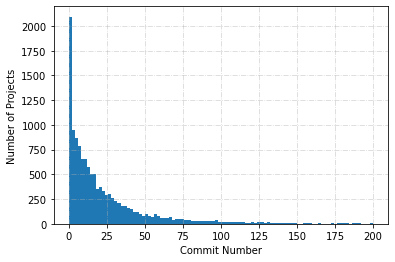

1371

In [69]:
from matplotlib import pyplot as plt
def draw_hist(x, xlabel, ylabel, bins, range:tuple):
    plt.figure() #初始化一张图
    plt.hist(x, bins=bins, range=range)  #直方图关键操作
    plt.grid(alpha=0.5,linestyle='-.') #网格线，更好看 
    plt.xlabel(xlabel)  
    plt.ylabel(ylabel)  
    # plt.title(r'Life cycle frequency distribution histogram of events in New York') 
    plt.show()
# draw_hist(star_num, 'Star Number', 'Number of Projects', 100, (0, 2000))
# draw_hist(df_requirements_commit['commit_num'].values, 'Commit Number', 'Number of Projects', 100, (0, 200))
draw_hist(df_setup_commit['commit_num'].values, 'Commit Number', 'Number of Projects', 100, (0, 200))
max(df_setup_commit['commit_num'].values)
# df_requirements_commit[df_requirements_commit['commit_num']==1098]
# count = 0
# for r in df_requirements_commit['commit_num'].values:
#     if r < 25:
#         count += 1
# print(count)
# print(df_requirements_commit['commit_num'].values)

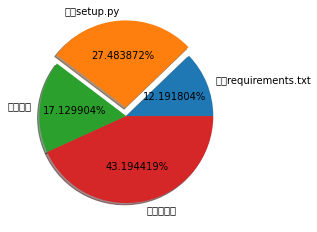

In [29]:
import numpy as np
import matplotlib.pyplot as plt

# 3496个项目只有requirements
# 7881个项目只有setup.py
# 4912个项目两者都有
# 12386个项目两者都没有

labels ='只有requirements.txt','只有setup.py','两者都有','两者都没有'
fraces = [3496,7881,4912,12386]
explode = [0,0.1,0,0]
plt.axes(aspect=1)
plt.pie(x=fraces,labels= labels,autopct='%0f%%',explode= explode,shadow=True)
plt.show()